# Surname classification

## DMiA 2018 (spring) Спорт

Домашнее задание 1

Выполнил: Скрипов Денис

18 место(0.92735 на private leaderboard)

---

В этой тетрадке я сконцентрировался на XGBoost и коллекционировании признаков. :)
К сожалению, я не занимался отбором признаков, хотя такая деятельсность давала сильный прирост.

Дополнительно к тем признакам, что я здесь описал я хотел попробовать библиотеку
<a href="https://github.com/deepmipt/ner">deepmipt/ner</a>, но при использовании ее возникли сложности(связанные с классом Extractor и тем, что он не может выгрузить свои данные с сервера).

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from pandas.tools.plotting import scatter_matrix

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
import gc
import re

pd.set_option.max_columns = None
pd.set_option.max_rows = None

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train =pd.read_csv('./train.csv', sep=',', encoding='utf8')
test =pd.read_csv('./test.csv', sep=',', encoding='utf8')

### Features отсюда: <a href="https://www.kaggle.com/c/dmia-surnames-classification/discussion/50123">ссылка</a>

In [3]:
def count_v1(word):
    vowels = 0
    consonants = 0
    vowels = sum(1 for x in word.lower() if x in 'аеёиоюэя')
    consonants = sum(1 for x in word.lower() if x in 'бвгджзклмнпрстфхцчшщ')
    return vowels, consonants

def count_v2(word):
    ship = 0
    swist = 0
    ship = sum(1 for x in word.lower() if x in 'жчшщ')
    swist = sum(1 for x in word.lower() if x in 'цзс')
    return ship, swist

def count_v3(word):
    zvon_parn = 0
    zvon_neparn = 0
    glukh_parn = 0
    glukh_neparn = 0
    zvon_parn = sum(1 for x in word.lower() if x in 'бвгджз')
    glukh_parn = sum(1 for x in word.lower() if x in 'пфктшс')
    zvon_neparn = sum(1 for x in word.lower() if x in 'лмнрй')
    glukh_neparn = sum(1 for x in word.lower() if x in 'хцчщ')
    return zvon_parn, zvon_neparn, glukh_parn, glukh_neparn

def count_v4(word):
    upper = 0
    lower = 0
    upper = sum(1 for x in word if x.isupper())
    lower = sum(1 for x in word if x.islower())
    return upper, lower

import re
def count_v5(word):
    spec = 0
    alphanum = 0
    whitesp = 0
    spec = len(re.sub('[^\^&*$]+' ,'', word))
    alphanum = sum(1 for x in word if re.findall('[а-яА-Я0-9]', x))
    whitesp = sum(1 for x in word if re.findall('[\s]', x))
    return spec, alphanum, whitesp


In [4]:
def feature_gen(train):
    X_add = pd.DataFrame()
    X_add['length'] = train.iloc[:, 0].astype(str).str.len()

    counts = train.iloc[:, 0].apply(count_v1)
    counts = pd.DataFrame(counts.tolist())
    X_add['vowels'] = counts[0]
    X_add['consonants'] = counts[1]

    counts = train.iloc[:, 0].apply(count_v2)
    counts = pd.DataFrame(counts.tolist())
    X_add['ship'] = counts[0]
    X_add['swist'] = counts[1]

    counts = train.iloc[:, 0].apply(count_v3)
    counts = pd.DataFrame(counts.tolist())
    X_add['zvon_parn'] = counts[0]
    X_add['glukh_parn'] = counts[1]
    X_add['zvon_neparn'] = counts[2]
    X_add['glukh_neparn'] = counts[3]

    counts = train.iloc[:, 0].apply(count_v4)
    counts = pd.DataFrame(counts.tolist())
    X_add['upper'] = counts[0]
    X_add['lower'] = counts[1]

    counts = train.iloc[:, 0].apply(count_v5)
    counts = pd.DataFrame(counts.tolist())
    X_add['spec'] = counts[0]
    X_add['alphanum'] = counts[1]
    X_add['whitesp'] = counts[2]

    X_add['first_letter_cap'] = train.iloc[:,0].astype(str).str[0].str.isupper().astype(int)
    return X_add

In [5]:
X_add_train = feature_gen(train)

X_add_test = feature_gen(test)

In [6]:
X_add_train.columns

Index(['length', 'vowels', 'consonants', 'ship', 'swist', 'zvon_parn',
       'glukh_parn', 'zvon_neparn', 'glukh_neparn', 'upper', 'lower', 'spec',
       'alphanum', 'whitesp', 'first_letter_cap'],
      dtype='object')

### Еще немного "простых" свойств

In [7]:
def another_easy(X, train):
    df = X.copy()
    df['All_upper'] = train['Word'].apply(lambda x: 1 if (x.isupper()) else 0)
    df['All_lower'] = train['Word'].apply(lambda x: 1 if (x.islower()) else 0)
    return df

In [8]:
X_add_train = another_easy(X_add_train, train)
X_add_test = another_easy(X_add_test, test)

In [9]:
all_data = pd.concat([train , test])

sample = pd.read_csv('sample_submission.csv')

### Добавим pymorphy2

In [10]:
from sklearn.model_selection import cross_val_score , StratifiedKFold

import pymorphy2
from sklearn.preprocessing import LabelEncoder

In [11]:
%%time
morph = pymorphy2.MorphAnalyzer()

all_data['pymorphy'] = all_data['Word'].apply(lambda x: morph.tag(x)[0])

all_data['pymorphy_animacy'] = all_data['pymorphy'].apply(lambda x: x.animacy)
all_data['pymorphy_POS'] = all_data['pymorphy'].apply(lambda x: x.POS)
all_data['pymorphy_case'] = all_data['pymorphy'].apply(lambda x: x.case)
all_data['pymorphy_number'] = all_data['pymorphy'].apply(lambda x: x.number)
all_data['pymorphy_gender'] = all_data['pymorphy'].apply(lambda x: x.gender)

all_data.drop('pymorphy' , axis=1 , inplace=True)

columns_to_one_hot = ['pymorphy_animacy', 'pymorphy_POS', 'pymorphy_case','pymorphy_number', 'pymorphy_gender']

for col in columns_to_one_hot:
    all_data[col] = LabelEncoder().fit_transform(list(all_data[col].fillna('nan')))

CPU times: user 10.7 s, sys: 150 ms, total: 10.9 s
Wall time: 11.2 s


In [12]:
new_train = all_data[all_data['Label'].notnull()]
new_test = all_data[all_data['Label'].isnull()]

In [13]:
new_train.columns

Index(['Label', 'Word', 'pymorphy_animacy', 'pymorphy_POS', 'pymorphy_case',
       'pymorphy_number', 'pymorphy_gender'],
      dtype='object')

In [14]:
def add_feats(df, dff):
    dt = dff.copy().drop(['Label', "Word"], axis=1)
    dt = pd.concat([dt, df], axis=1)
    return dt

In [15]:
X_feats_train = add_feats(X_add_train, new_train)
X_feats_test = add_feats(X_add_test, new_test)

### Добавим фичу от Natasha

In [16]:
from natasha import NamesExtractor

In [17]:
def natasha_feats(df, train):
    name_extractor = NamesExtractor()
    natasha_names = lambda word: 1 if len(name_extractor(word).as_json) > 0 else 0 #1 or 0
    df['Natasha'] = train['Word'].apply(natasha_names)
    return df

In [18]:
X_feats_train = natasha_feats(X_feats_train, train)
X_feats_test = natasha_feats(X_feats_test, test)

In [19]:
col = [c for c in train if c not in ['Word','Label']]
col2 = [c for c in test if c not in ['Word']]

In [20]:
train_full = train[col]
test_full = test[col2]

### <a href="https://github.com/MyLtYkRiTiK/tutorials/blob/master/Easy_XGB_starter.ipynb">Запихнем все это в XGBoost!</a>

In [21]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(X_feats_train, train['Label'], random_state=42)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect();

Binding to float32
Building DMatrix...


In [22]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.9,
          #'colsample_bytree': 0.7,  
          #'colsample_bylevel': 0.7,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.5, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_feats_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.897469	valid-auc:0.885223
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.91532	valid-auc:0.903049
[20]	train-auc:0.920626	valid-auc:0.905413
[30]	train-auc:0.924282	valid-auc:0.906189
[40]	train-auc:0.92657	valid-auc:0.90636
[50]	train-auc:0.928836	valid-auc:0.906534
[60]	train-auc:0.931231	valid-auc:0.906573
[70]	train-auc:0.933246	valid-auc:0.906486
[80]	train-auc:0.934851	valid-auc:0.906537
[90]	train-auc:0.936182	valid-auc:0.906565
[100]	train-auc:0.937269	valid-auc:0.906192
[110]	train-auc:0.938335	valid-auc:0.906185
[120]	train-auc:0.939409	valid-auc:0.906209
[130]	train-auc:0.940176	valid-auc:0.905912
[140]	train-auc:0.940911	valid-auc:0.905929
Stopping. Best iteration:
[48]	train-auc:0.928426	valid-auc:0.906856

AUC XgBoost:  0.9325978401494613


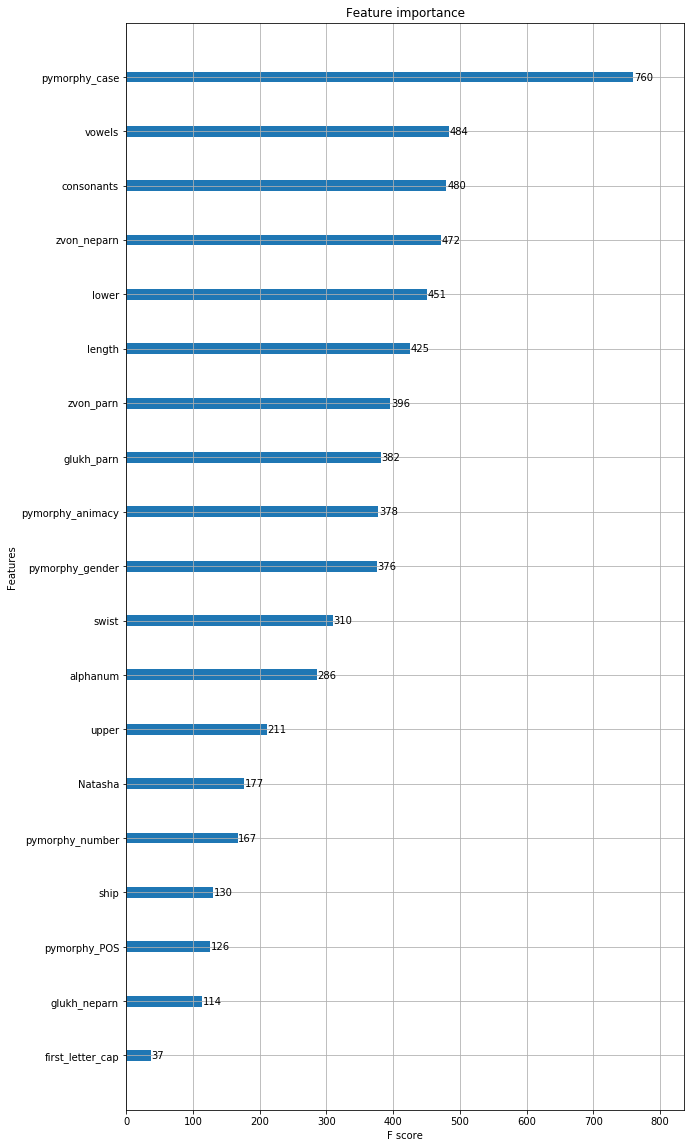

In [23]:
def my_plot_importance(booster, figsize, **kwargs): 
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(model1, (10,20));

In [24]:
x_test = X_feats_test.copy()
d_test = xgb.DMatrix(x_test)
X_feats_train.shape, X_feats_test.shape

((101408, 23), (188920, 23))

In [25]:
sub = pd.read_csv('sample_submission.csv')
sub = sub.reset_index(drop=True)
sub.head()

,Id,Prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [26]:
sub['Prediction'] = model1.predict(d_test)
sub.head(10)

,Id,Prediction
0,0,0.402438
1,1,0.256448
2,2,0.033619
3,3,0.199274
4,4,0.186347
5,5,0.149281
6,6,0.342522
7,7,0.252916
8,8,0.252916
9,9,0.522856


In [27]:
sub.to_csv('submission_easy_xgb_feats1.csv', columns=['Id', 'Prediction'], index=False)

In [28]:
src_all_data = all_data[['Word', 'Label']]

### Добавим Tf-Idf

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [30]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1,10), max_features = 128 , encoding='utf8')

for_tf_idf = ngram_vectorizer.fit_transform(src_all_data.Word.apply(str.lower).tolist())

tfidf_sparse = TfidfTransformer().fit_transform(for_tf_idf)

In [31]:
tfidf = pd.DataFrame(tfidf_sparse.toarray() , index=all_data.index, columns=['tf_idf_' + str(i) for i in range(tfidf_sparse.shape[1])])

In [32]:
test.index + len(train)

RangeIndex(start=101408, stop=290328, step=1)

In [33]:
tfidf_train = tfidf.iloc[train.index]
tfidf_test = tfidf.iloc[test.index + len(train)]

In [34]:
X_feats_tfidf_train = pd.concat([X_feats_train, tfidf_train], axis=1)
X_feats_tfidf_test = pd.concat([X_feats_test, tfidf_test], axis=1)

In [35]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(X_feats_tfidf_train, train['Label'], random_state=42)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect();

Binding to float32
Building DMatrix...


In [36]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.9,
          #'colsample_bytree': 0.7,  
          #'colsample_bylevel': 0.7,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.5, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_feats_tfidf_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.899164	valid-auc:0.883278
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.931004	valid-auc:0.913619
[20]	train-auc:0.937964	valid-auc:0.915867
[30]	train-auc:0.942783	valid-auc:0.916689
[40]	train-auc:0.947121	valid-auc:0.917382
[50]	train-auc:0.950348	valid-auc:0.91739
[60]	train-auc:0.95258	valid-auc:0.916753
[70]	train-auc:0.954702	valid-auc:0.916929
[80]	train-auc:0.957125	valid-auc:0.916487
[90]	train-auc:0.959236	valid-auc:0.915763
[100]	train-auc:0.961083	valid-auc:0.916404
[110]	train-auc:0.962842	valid-auc:0.916908
[120]	train-auc:0.964054	valid-auc:0.916604
[130]	train-auc:0.965429	valid-auc:0.916297
[140]	train-auc:0.966518	valid-auc:0.916617
Stopping. Best iteration:
[44]	train-auc:0.948398	valid-auc:0.917667

AUC XgBoost:  0.9544796287897471


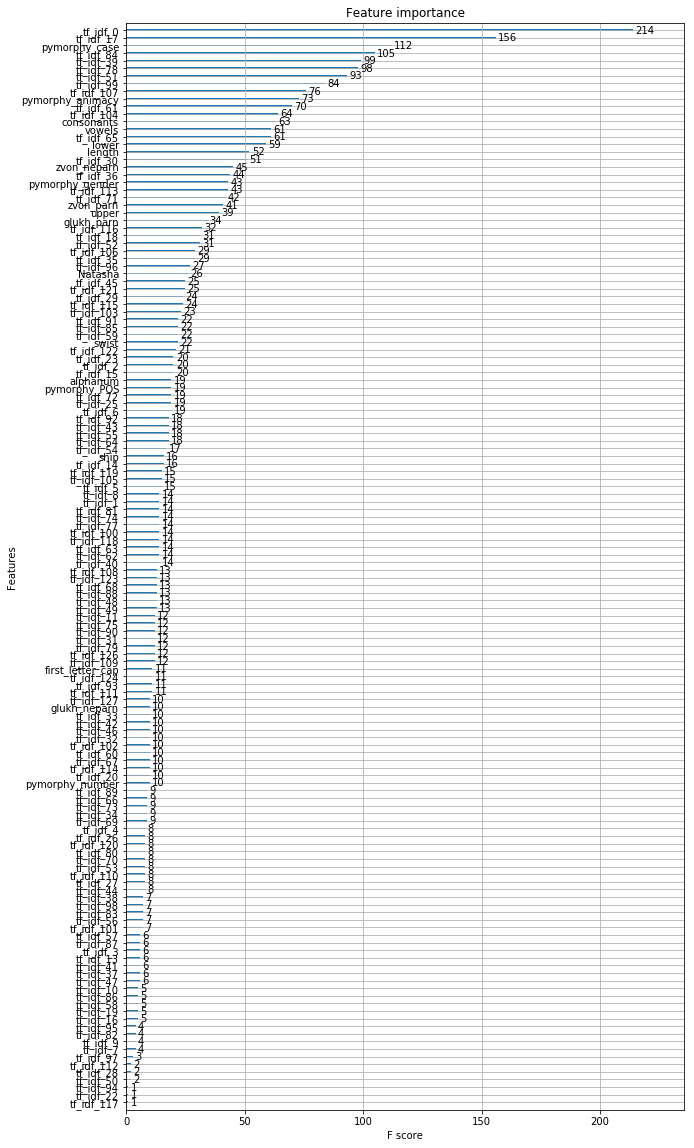

In [37]:
my_plot_importance(model1, (10,20));

In [38]:
x_test = X_feats_tfidf_test.copy()
d_test = xgb.DMatrix(x_test)
X_feats_tfidf_train.shape, X_feats_tfidf_test.shape

((101408, 151), (188920, 151))

In [39]:
sub['Prediction'] = model1.predict(d_test)
sub.head(10)

,Id,Prediction
0,0,0.199363
1,1,0.427606
2,2,0.036750
3,3,0.039813
4,4,0.074016
5,5,0.284502
6,6,0.498993
7,7,0.148189
8,8,0.148189
9,9,0.205475


In [40]:
sub.to_csv('submission_easy_xgb_feats_tfidf2.csv', columns=['Id', 'Prediction'], index=False)

### Добавим свойства из бэйзлайна w2v(из телеграмма)

In [41]:
from IPoet2 import slogTokenizer3

slogTokenizer3('Доблестный')

['До', 'бле', 'стный']

In [42]:
data_for_word2vec = pd.concat([train[['Word']], test[['Word']]])

In [43]:
import re

def prepare_df(df):
    vowels = set('аоиеёэыуюя')
    
    df.loc[:, 'word'] = df['Word'].apply(lambda x: re.sub("[^а-я]", "", x.lower()))
    df.loc[:, 'vowels'] = df['word'].apply(lambda word: sum(letter in vowels for letter in word))
    
    return df

data_for_word2vec = prepare_df(data_for_word2vec)

In [44]:
data_for_word2vec[data_for_word2vec['vowels']==data_for_word2vec['vowels'].max()]

,Word,word,vowels
132521,Райффайзен Интернациональ Банк-Холдинг,райффайзенинтернациональбанкхолдинг,12


In [45]:
def slog(word):
    return (slogTokenizer3(word) + ['']*11)[:8]

data_for_word2vec['list_w'] = data_for_word2vec['word'].apply(slog)

In [46]:
from gensim.models import word2vec

modelw2v = word2vec.Word2Vec(data_for_word2vec['list_w'], size=128, window=3, workers=6)

In [47]:
w2v = dict(zip(modelw2v.wv.index2word, modelw2v.wv.syn0))

In [48]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))
    
    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [49]:
train_w2v = prepare_df(train)
train_w2v['list_w'] = train_w2v['word'].apply(slog)
train_w2v.head()

,Word,Label,word,vowels,list_w
0,Аалтонен,1,аалтонен,4,"[а, а, лто, нен, , , , ]"
1,Аар,0,аар,2,"[а, ар, , , , , , ]"
2,Аарон,0,аарон,3,"[а, а, рон, , , , , ]"
3,ААРОН,0,аарон,3,"[а, а, рон, , , , , ]"
4,Аарона,0,аарона,4,"[а, а, ро, на, , , , ]"


In [50]:
train_matrix = mean_vectorizer(w2v).fit(train['list_w']).transform(train['list_w'])
print(train_matrix.shape)

(101408, 128)


In [51]:
test_w2v = prepare_df(test)
test_w2v['list_w'] = test_w2v['word'].apply(slog)
test_matrix = mean_vectorizer(w2v).fit(test_w2v['list_w']).transform(test_w2v['list_w'])
print(test_matrix.shape)

(188920, 128)


In [52]:
w2v_matrix_train = pd.DataFrame(
    train_matrix, 
    index=train.index, 
    columns=['w2v_' + str(i) for i in range(train_matrix.shape[1])]
)

w2v_matrix_test = pd.DataFrame(
    test_matrix, 
    index=test.index, 
    columns=['w2v_' + str(i) for i in range(test_matrix.shape[1])]
)

In [53]:
X_feats_tfidf_w2v_train = pd.concat([X_feats_tfidf_train, w2v_matrix_train], axis=1)
X_feats_tfidf_w2v_test = pd.concat([X_feats_tfidf_test, w2v_matrix_test], axis=1)

In [54]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(X_feats_tfidf_w2v_train, train['Label'], random_state=42)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect();

Binding to float32
Building DMatrix...


In [55]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.9,
          'colsample_bytree': 0.9,  
          'colsample_bylevel': 0.9,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.1, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_feats_tfidf_w2v_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.901431	valid-auc:0.882908
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.924505	valid-auc:0.899838
[20]	train-auc:0.929776	valid-auc:0.903607
[30]	train-auc:0.935595	valid-auc:0.909635
[40]	train-auc:0.940863	valid-auc:0.91415
[50]	train-auc:0.945007	valid-auc:0.915802
[60]	train-auc:0.948081	valid-auc:0.916963
[70]	train-auc:0.950143	valid-auc:0.917707
[80]	train-auc:0.952743	valid-auc:0.91867
[90]	train-auc:0.954607	valid-auc:0.918998
[100]	train-auc:0.956889	valid-auc:0.918899
[110]	train-auc:0.958595	valid-auc:0.918963
[120]	train-auc:0.960144	valid-auc:0.919005
[130]	train-auc:0.961757	valid-auc:0.918988
[140]	train-auc:0.963372	valid-auc:0.918986
[150]	train-auc:0.96525	valid-auc:0.918931
[160]	train-auc:0.966372	valid-auc:0.919109
[170]	train-auc:0.967578	valid-auc:0.91919
[180]	train-auc:0.968651	valid-auc:0.919234
[190]	train-auc:0.9702

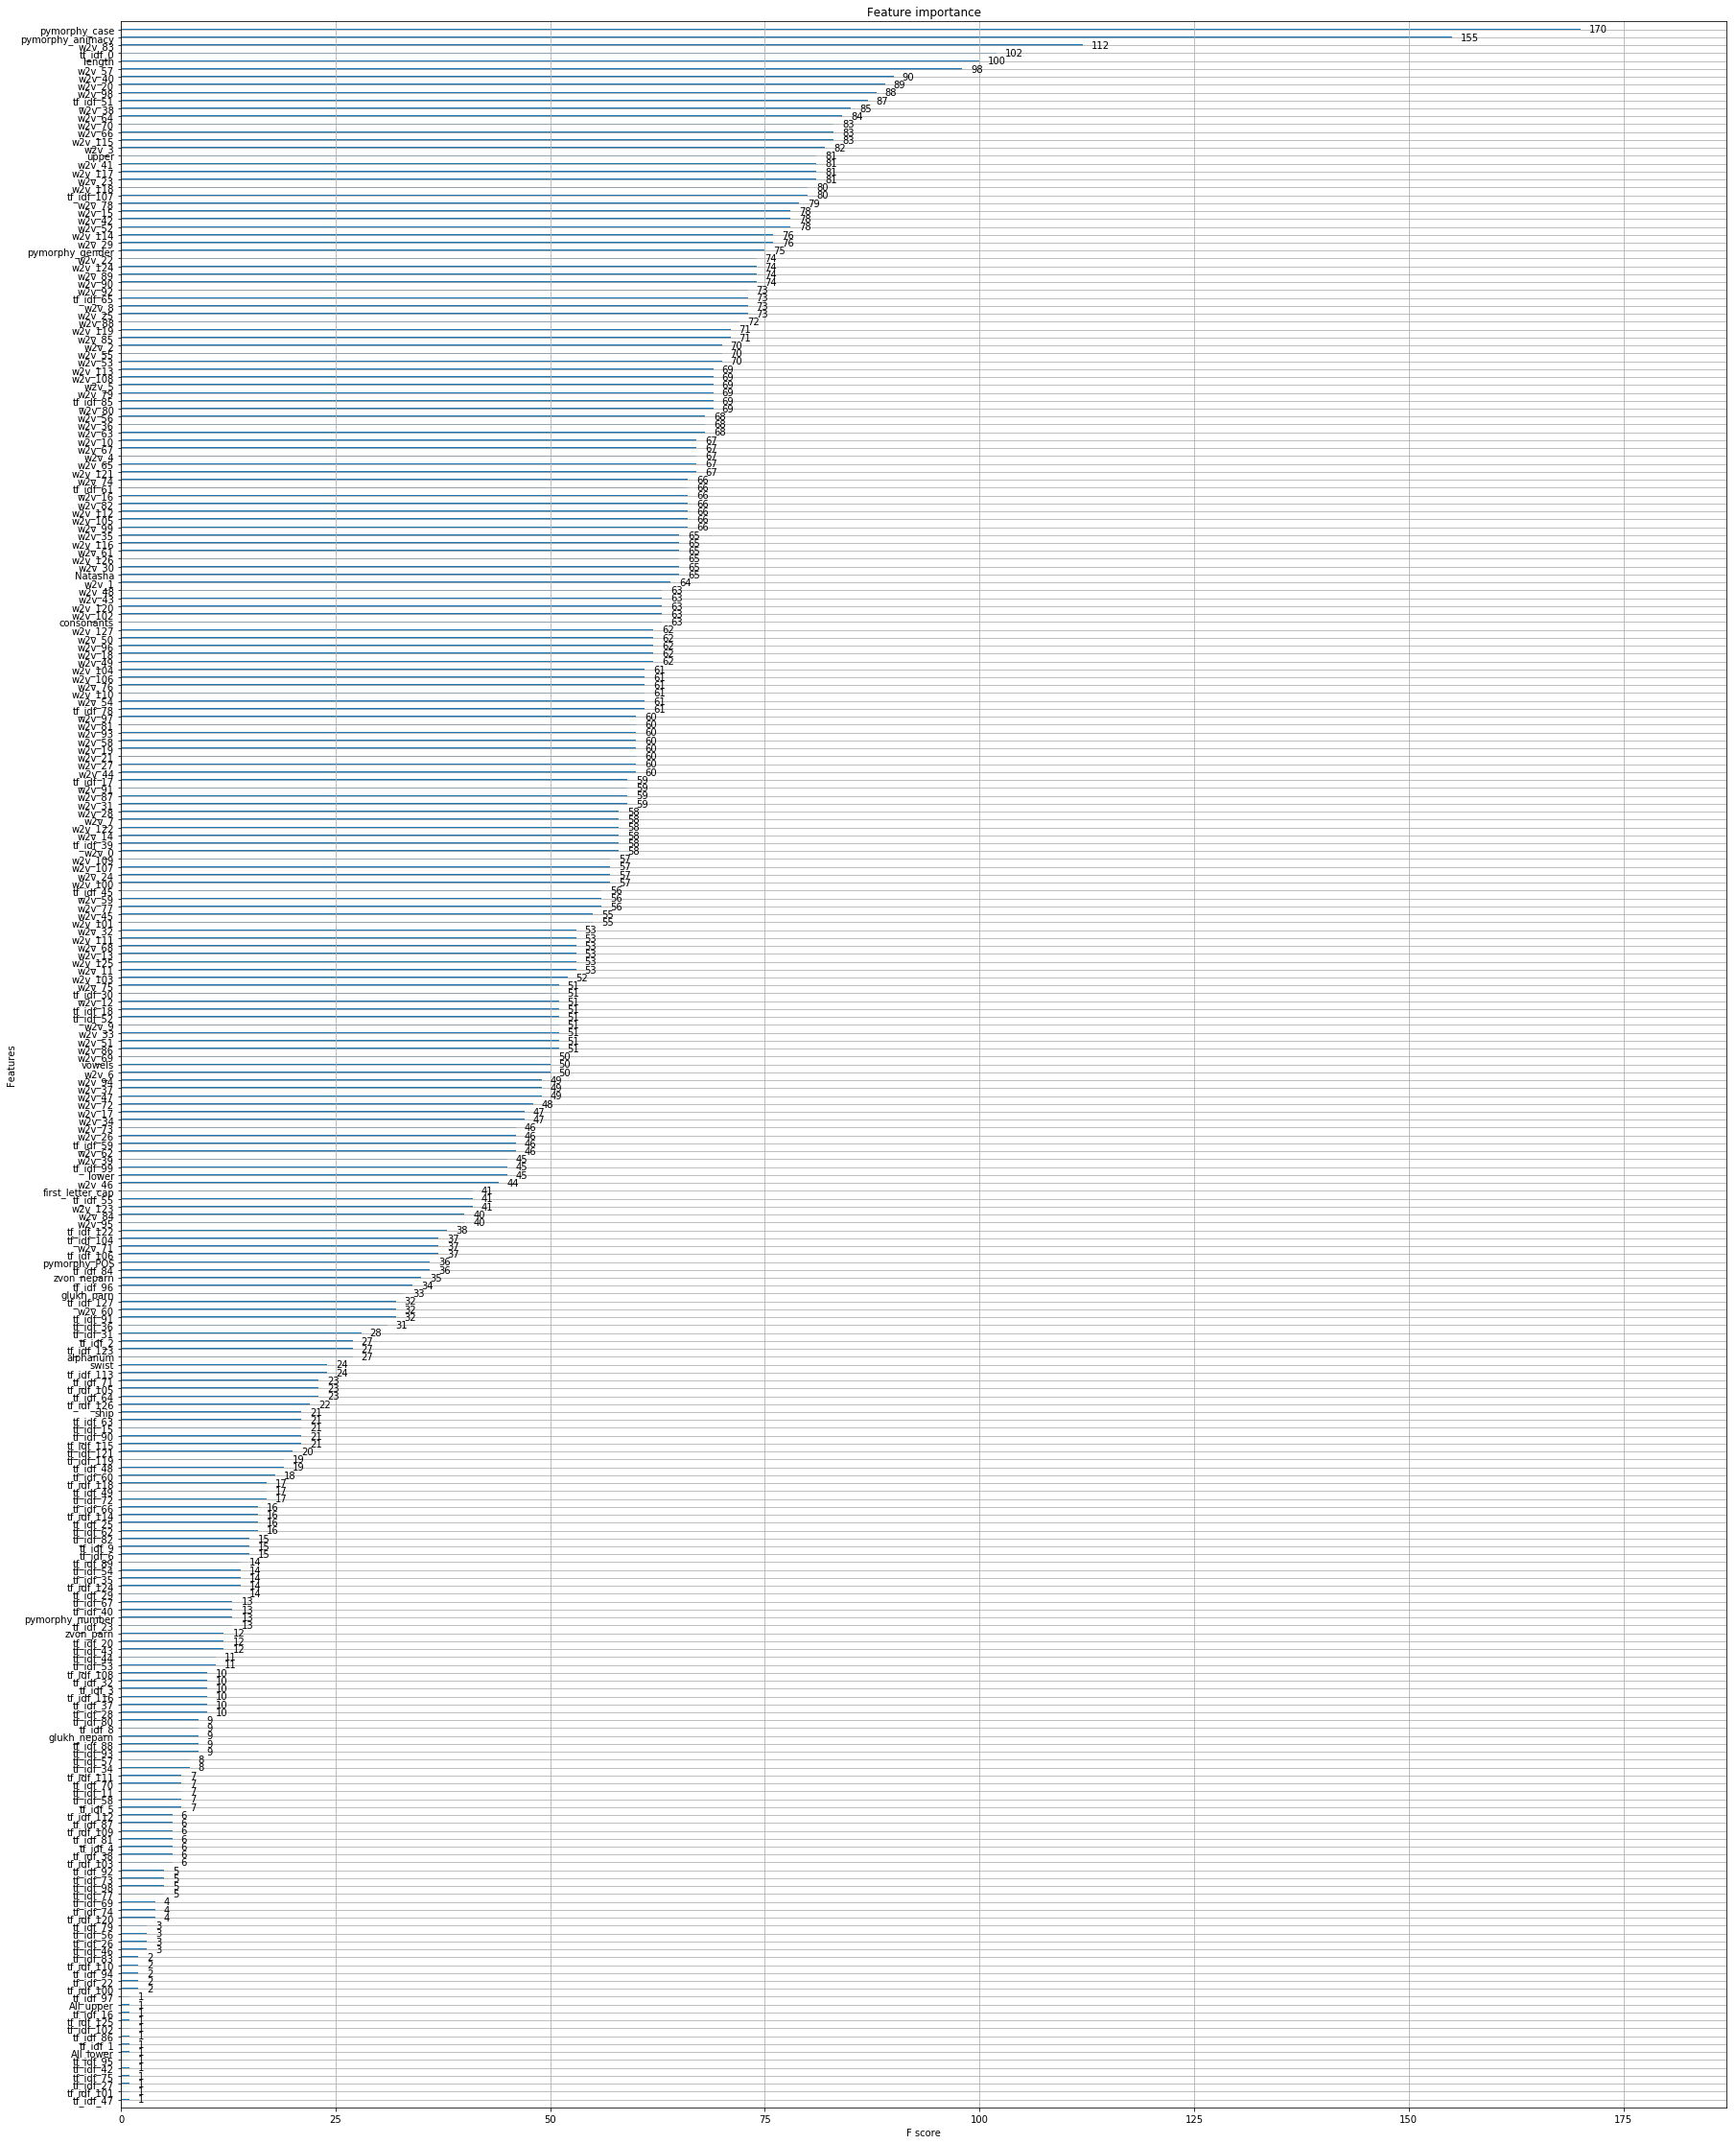

In [56]:
my_plot_importance(model1, (30,40));

In [57]:
x_test = X_feats_tfidf_w2v_test.copy()
d_test = xgb.DMatrix(x_test)
X_feats_tfidf_w2v_train.shape, X_feats_tfidf_w2v_test.shape

((101408, 279), (188920, 279))

In [58]:
sub['Prediction'] = model1.predict(d_test)
sub.head(10)

,Id,Prediction
0,0,0.282437
1,1,0.101240
2,2,0.159231
3,3,0.101753
4,4,0.176521
5,5,0.133121
6,6,0.569820
7,7,0.201972
8,8,0.201972
9,9,0.273265


In [59]:
sub.to_csv('submission_easy_xgb_feats_w2v_3.csv', columns=['Id', 'Prediction'], index=False)

### Another easy features(<a href="https://github.com/anatolyburtsev/ml_notebooks/blob/master/DMIA_2018/sport_hw0/real_solution.ipynb">ссылочка</a>)

In [60]:
set1 = set(train['Word'])
words = ' '.join(set1).split()
words = [list(set(' '.join(word).split())) for word in words]
letters = []
for x in words:
    letters += x
letters = set(letters)

In [61]:
#letters

In [62]:
full_text = pd.concat([train, test])[['Word']]
full_text['Word'] = full_text['Word'].apply(lambda word: word.lower())
vowel = u'уеёыаоэяию'
consonant = u'йцкнгшщзхъфвпрлджчсмтьб'
ru_letter = vowel + consonant + u"-’'"
last_letter = list(set(full_text["Word"].apply(lambda x: x[-1]).get_values()))
last_2_letter = list(set(full_text["Word"].apply(lambda x: x[-2:]).get_values()))
last_3_letter = list(set(full_text["Word"].apply(lambda x: x[-3:]).get_values()))

In [63]:
def is_only_ru(word):
    return len(set(word) - set(ru_letter)) == 0

In [64]:
from tqdm import tqdm

In [65]:
def add_another_features(dt, train):
    df = dt.copy()
    df['is_only_ru'] = train['Word'].apply(lambda word: 1 if is_only_ru(word) else 0)
    df['Not_null_Consonants'] = df['consonants'].apply(lambda x: 0.001 if x==0 else x)
    df['Vow/Conson'] = df['vowels'] / df['Not_null_Consonants']
    df.drop(['Not_null_Consonants'], axis=1, inplace=True)
    df["last_vow"] = train["Word"].apply(lambda x: x[-1] in vowel)
    df["prelast_vow"] = train["Word"].apply(lambda x: len(x) > 2 and x[-2] in vowel)
    df["ohara"] = train["Word"].apply(lambda x: x[:2] == "о'")
    df["is_len_more_11"] = df["length"].apply(lambda x: x > 11)
    return df

In [66]:
X_plus_easy_train = add_another_features(X_feats_tfidf_w2v_train, train)
X_plus_easy_test = add_another_features(X_feats_tfidf_w2v_test, test)

In [67]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(X_plus_easy_train, train['Label'], random_state=42)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect();

Binding to float32
Building DMatrix...


In [68]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.9,
          #'colsample_bytree': 0.7,  
          #'colsample_bylevel': 0.7,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.5, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_plus_easy_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.903371	valid-auc:0.88257
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.941524	valid-auc:0.908699
[20]	train-auc:0.953906	valid-auc:0.909651
[30]	train-auc:0.962325	valid-auc:0.906989
[40]	train-auc:0.969346	valid-auc:0.906747
[50]	train-auc:0.973921	valid-auc:0.905024
[60]	train-auc:0.978797	valid-auc:0.905201
[70]	train-auc:0.982314	valid-auc:0.904171
[80]	train-auc:0.985215	valid-auc:0.903351
[90]	train-auc:0.987655	valid-auc:0.902255
[100]	train-auc:0.989881	valid-auc:0.902414
[110]	train-auc:0.991494	valid-auc:0.902606
Stopping. Best iteration:
[14]	train-auc:0.947214	valid-auc:0.910419

AUC XgBoost:  0.9712783496331641


In [69]:
my_plot_importance(model1, (200, 200));

### Using nltk

In [70]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

In [71]:
train['part'] = train['Word'].apply(lambda word: pos_tag(word_tokenize(word + " "), lang='rus')[0][1])
test['part'] = test['Word'].apply(lambda word: pos_tag(word_tokenize(word + " "), lang='rus')[0][1])

dic = train['part'].copy()
dic = dic.append(test['part'].copy())

In [72]:
dic = dic.unique()

In [73]:
le = LabelEncoder().fit(dic)

In [74]:
X_nltk_train = X_plus_easy_train.copy()
X_nltk_test = X_plus_easy_test.copy()

X_nltk_train['pos_nltk'] = le.transform(train['part'])
X_nltk_test['pos_nltk'] = le.transform(test['part'])

In [75]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(X_nltk_train, train['Label'], random_state=42)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect();

Binding to float32
Building DMatrix...


In [76]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.9,
          #'colsample_bytree': 0.7,  
          #'colsample_bylevel': 0.7,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.5, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_nltk_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.903363	valid-auc:0.881325
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.942219	valid-auc:0.911555
[20]	train-auc:0.95386	valid-auc:0.913497
[30]	train-auc:0.961631	valid-auc:0.912048
[40]	train-auc:0.968269	valid-auc:0.910588
[50]	train-auc:0.974376	valid-auc:0.909221
[60]	train-auc:0.978763	valid-auc:0.90776
[70]	train-auc:0.98288	valid-auc:0.906097
[80]	train-auc:0.986161	valid-auc:0.904734
[90]	train-auc:0.988481	valid-auc:0.903621
[100]	train-auc:0.990531	valid-auc:0.903744
[110]	train-auc:0.99245	valid-auc:0.90383
[120]	train-auc:0.993684	valid-auc:0.903764
Stopping. Best iteration:
[20]	train-auc:0.95386	valid-auc:0.913497

AUC XgBoost:  0.9726493905011008


In [77]:
my_plot_importance(model1, (300, 300));

### Distance between original and stemmed word(добавим редакторское, jaccard и masi расстояния)

In [78]:
from nltk.stem.snowball import RussianStemmer
from nltk.metrics.distance import edit_distance, jaccard_distance, masi_distance

In [79]:
stemmer = RussianStemmer()

In [80]:
train['stemmed'] = train['Word'].apply(lambda word: stemmer.stem(word))
test['stemmed'] = test['Word'].apply(lambda word: stemmer.stem(word))

In [81]:
X_metrics_train = X_nltk_train.copy()
X_metrics_test = X_nltk_test.copy()

X_metrics_train['edit'] = [edit_distance(train['stemmed'][idx], train['word'][idx]) for idx in range(len(train))]
X_metrics_test['edit'] = [edit_distance(test['stemmed'][idx], test['word'][idx]) for idx in range(len(test))]
X_metrics_train['jaccard'] = [jaccard_distance(set(train['stemmed'][idx]), set(train['word'][idx])) for idx in range(len(train))]
X_metrics_test['jaccard'] = [jaccard_distance(set(test['stemmed'][idx]), set(test['word'][idx])) for idx in range(len(test))]
X_metrics_train['masi'] = [masi_distance(set(train['stemmed'][idx]), set(train['word'][idx])) for idx in range(len(train))]
X_metrics_test['masi'] = [masi_distance(set(test['stemmed'][idx]), set(test['word'][idx])) for idx in range(len(test))]

In [82]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(X_metrics_train, train['Label'], random_state=42)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect();

Binding to float32
Building DMatrix...


In [83]:
print('Training ...')

params = {'max_depth': 15, 
          'min_child_weight': 50, 
          #'subsample': 0.75,
          'colsample_bytree': 0.9,  
          'colsample_bylevel': 0.9,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.1, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42,
          'scale_pos_weight': len(train[train['Label']==0])/len(train[train['Label']!=0])
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_metrics_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.924855	valid-auc:0.87707
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.959198	valid-auc:0.91014
[20]	train-auc:0.968672	valid-auc:0.916891
[30]	train-auc:0.975729	valid-auc:0.920206
[40]	train-auc:0.980834	valid-auc:0.921973
[50]	train-auc:0.984246	valid-auc:0.922818
[60]	train-auc:0.986477	valid-auc:0.923322
[70]	train-auc:0.988122	valid-auc:0.923692
[80]	train-auc:0.989716	valid-auc:0.923887
[90]	train-auc:0.990978	valid-auc:0.923972
[100]	train-auc:0.99231	valid-auc:0.924246
[110]	train-auc:0.993138	valid-auc:0.924185
[120]	train-auc:0.993891	valid-auc:0.924123
[130]	train-auc:0.994631	valid-auc:0.923962
[140]	train-auc:0.995269	valid-auc:0.924018
[150]	train-auc:0.995647	valid-auc:0.924084
[160]	train-auc:0.996064	valid-auc:0.923859
[170]	train-auc:0.996364	valid-auc:0.923849
[180]	train-auc:0.996656	valid-auc:0.923622
[190]	train-auc:0.996

In [84]:
x_test = X_metrics_test.copy()
d_test = xgb.DMatrix(x_test)
print(X_metrics_train.shape, X_metrics_test.shape)
sub['Prediction'] = model1.predict(d_test)
print(sub.head(10))

(101408, 289) (188920, 289)
   Id  Prediction
0   0    0.591639
1   1    0.159509
2   2    0.164497
3   3    0.108193
4   4    0.158270
5   5    0.215239
6   6    0.844677
7   7    0.289209
8   8    0.289209
9   9    0.421711


In [85]:
#my_plot_importance(model1, (50, 50));

In [86]:
x_test = X_metrics_test.copy()
d_test = xgb.DMatrix(x_test)
print(X_metrics_train.shape, X_metrics_test.shape)
sub['Prediction'] = model1.predict(d_test)
print(sub.head(10))
sub.to_csv('submission_xgb_metrics_final_2.csv', columns=['Id', 'Prediction'], index=False)

(101408, 289) (188920, 289)
   Id  Prediction
0   0    0.591639
1   1    0.159509
2   2    0.164497
3   3    0.108193
4   4    0.158270
5   5    0.215239
6   6    0.844677
7   7    0.289209
8   8    0.289209
9   9    0.421711


### PyMyStem3(<a href="https://github.com/KirillTushin/Surnames_classification/blob/master/natasha_pymystem.ipynb">ссылка</a>)

In [87]:
!pip3 install git+https://github.com/nlpub/pymystem3

The directory '/home/nizhikebinesi/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/nizhikebinesi/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
  Cloning https://github.com/nlpub/pymystem3 to /tmp/pip-l91hk5al-build


In [88]:
import pymystem3

In [89]:
mystem = pymystem3.Mystem()

In [90]:
mystem.analyze("Васин")

[{'analysis': [{'gr': 'S,фам,муж,од=им,ед', 'lex': 'васин'}], 'text': 'Васин'},
 {'text': '\n'}]

In [91]:
%%time

def name_from_pymystem(word):
    try:
        return 1 if 'имя' in mystem.analyze(word)[0]['analysis'][0]['gr'].split(',') else 0
    except:
        return 0

def surn_from_pymystem(word):
    try:
        return 1 if 'фам' in mystem.analyze(word)[0]['analysis'][0]['gr'].split(',') else 0
    except:
        return 0

def add_pymystem3_feats(df, train):
    dt = df.copy()
    dt['name_from_pymystem'] = train['Word'].apply(name_from_pymystem)
    dt['surn_from_pymystem'] = train['Word'].apply(surn_from_pymystem)
    return dt

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


In [92]:
%%time
X_pymystem3_train = add_pymystem3_feats(X_metrics_train, train)
X_pymystem3_test = add_pymystem3_feats(X_metrics_test, test)

CPU times: user 14.1 s, sys: 3.7 s, total: 17.8 s
Wall time: 36 s


In [93]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(X_pymystem3_train, train['Label'], random_state=42)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect();

Binding to float32
Building DMatrix...


In [94]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.75,
          'colsample_bytree': 0.9,  
          'colsample_bylevel': 0.6,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.09, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42,
          'scale_pos_weight': len(train[train['Label']==0])/len(train[train['Label']!=0])
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_pymystem3_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.918875	valid-auc:0.886179
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.954453	valid-auc:0.92336
[20]	train-auc:0.961946	valid-auc:0.928396
[30]	train-auc:0.967417	valid-auc:0.931234
[40]	train-auc:0.97145	valid-auc:0.932533
[50]	train-auc:0.975049	valid-auc:0.932977
[60]	train-auc:0.977697	valid-auc:0.933661
[70]	train-auc:0.979702	valid-auc:0.933947
[80]	train-auc:0.981239	valid-auc:0.934065
[90]	train-auc:0.982688	valid-auc:0.934237
[100]	train-auc:0.983916	valid-auc:0.93447
[110]	train-auc:0.985123	valid-auc:0.934709
[120]	train-auc:0.986155	valid-auc:0.934891
[130]	train-auc:0.986992	valid-auc:0.93463
[140]	train-auc:0.988065	valid-auc:0.934735
[150]	train-auc:0.988974	valid-auc:0.934798
[160]	train-auc:0.989715	valid-auc:0.93489
[170]	train-auc:0.990456	valid-auc:0.9347
[180]	train-auc:0.990987	valid-auc:0.934585
[190]	train-auc:0.991388	

In [95]:
print('Training ...')

params = {'max_depth': 15, 
          'min_child_weight': 50, 
          'subsample': 0.95,
          'colsample_bytree': 0.7,  
          'colsample_bylevel': 0.9,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.09, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42,
          'scale_pos_weight': len(train[train['Label']==0])/len(train[train['Label']!=0])
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_pymystem3_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.944108	valid-auc:0.909351
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.967472	valid-auc:0.92721
[20]	train-auc:0.974308	valid-auc:0.931493
[30]	train-auc:0.978677	valid-auc:0.932701
[40]	train-auc:0.982524	valid-auc:0.934178
[50]	train-auc:0.984856	valid-auc:0.934414
[60]	train-auc:0.986716	valid-auc:0.934588
[70]	train-auc:0.988132	valid-auc:0.934802
[80]	train-auc:0.989553	valid-auc:0.934851
[90]	train-auc:0.99057	valid-auc:0.934643
[100]	train-auc:0.991511	valid-auc:0.934637
[110]	train-auc:0.992461	valid-auc:0.934295
[120]	train-auc:0.993279	valid-auc:0.933993
[130]	train-auc:0.993865	valid-auc:0.934102
[140]	train-auc:0.994497	valid-auc:0.933909
[150]	train-auc:0.994907	valid-auc:0.933698
[160]	train-auc:0.995316	valid-auc:0.933576
[170]	train-auc:0.99571	valid-auc:0.933474
Stopping. Best iteration:
[76]	train-auc:0.989055	valid-auc:0.934

In [96]:
x_test = X_pymystem3_test.copy()
d_test = xgb.DMatrix(x_test)
print(X_pymystem3_train.shape, X_pymystem3_test.shape)
sub['Prediction'] = model1.predict(d_test)
sub.head(10)

(101408, 291) (188920, 291)


,Id,Prediction
0,0,0.592770
1,1,0.279673
2,2,0.197109
3,3,0.166816
4,4,0.159611
5,5,0.863181
6,6,0.692512
7,7,0.964600
8,8,0.964600
9,9,0.953348


In [97]:
sub.to_csv('submission_xgb_pymystem3_final_0.csv', columns=['Id', 'Prediction'], index=False)

In [98]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          'subsample': 0.9,
          'colsample_bytree': 0.55,  
          'colsample_bylevel': 0.99,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.1, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42,
          'scale_pos_weight': len(train[train['Label']==0])/len(train[train['Label']!=0])
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_pymystem3_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.908226	valid-auc:0.877595
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.954035	valid-auc:0.924093
[20]	train-auc:0.961143	valid-auc:0.929598
[30]	train-auc:0.966637	valid-auc:0.931946
[40]	train-auc:0.971328	valid-auc:0.933301
[50]	train-auc:0.974123	valid-auc:0.933747
[60]	train-auc:0.976553	valid-auc:0.93411
[70]	train-auc:0.978359	valid-auc:0.934214
[80]	train-auc:0.980324	valid-auc:0.934247
[90]	train-auc:0.981688	valid-auc:0.934263
[100]	train-auc:0.982937	valid-auc:0.934509
[110]	train-auc:0.984541	valid-auc:0.934576
[120]	train-auc:0.986184	valid-auc:0.934267
[130]	train-auc:0.987329	valid-auc:0.934499
[140]	train-auc:0.988105	valid-auc:0.934488
[150]	train-auc:0.988747	valid-auc:0.934409
[160]	train-auc:0.989581	valid-auc:0.934257
[170]	train-auc:0.990299	valid-auc:0.934277
[180]	train-auc:0.990822	valid-auc:0.934189
[190]	train-auc:0.9

In [99]:
x_test = X_pymystem3_test.copy()
d_test = xgb.DMatrix(x_test)
print(X_pymystem3_train.shape, X_pymystem3_test.shape)
sub['Prediction'] = model1.predict(d_test)
sub.head(10)

(101408, 291) (188920, 291)


,Id,Prediction
0,0,0.579213
1,1,0.564716
2,2,0.245159
3,3,0.208981
4,4,0.162282
5,5,0.745245
6,6,0.757470
7,7,0.943224
8,8,0.943224
9,9,0.962768


In [100]:
sub.to_csv('submission_xgb_pymystem3_final_1.csv', columns=['Id', 'Prediction'], index=False)

In [101]:
print('Training ...')

params = {'max_depth': 15, 
          'min_child_weight': 50, 
          #'subsample': 0.8,
          'colsample_bytree': 0.65,  
          'colsample_bylevel': 0.9,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.09, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 42,
          'scale_pos_weight': len(train[train['Label']==0])/len(train[train['Label']!=0])
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(X_pymystem3_train, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.929108	valid-auc:0.880123
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.968451	valid-auc:0.927469
[20]	train-auc:0.97486	valid-auc:0.930436
[30]	train-auc:0.980043	valid-auc:0.932213
[40]	train-auc:0.983668	valid-auc:0.933571
[50]	train-auc:0.986258	valid-auc:0.934344
[60]	train-auc:0.988114	valid-auc:0.934769
[70]	train-auc:0.989332	valid-auc:0.934947
[80]	train-auc:0.990525	valid-auc:0.934736
[90]	train-auc:0.991602	valid-auc:0.934908
[100]	train-auc:0.99232	valid-auc:0.93478
[110]	train-auc:0.993078	valid-auc:0.93486
[120]	train-auc:0.993756	valid-auc:0.934708
[130]	train-auc:0.99434	valid-auc:0.934674
[140]	train-auc:0.994736	valid-auc:0.934475
[150]	train-auc:0.995111	valid-auc:0.934275
[160]	train-auc:0.995539	valid-auc:0.934339
Stopping. Best iteration:
[68]	train-auc:0.989181	valid-auc:0.935028

AUC XgBoost:  0.9816821983828151


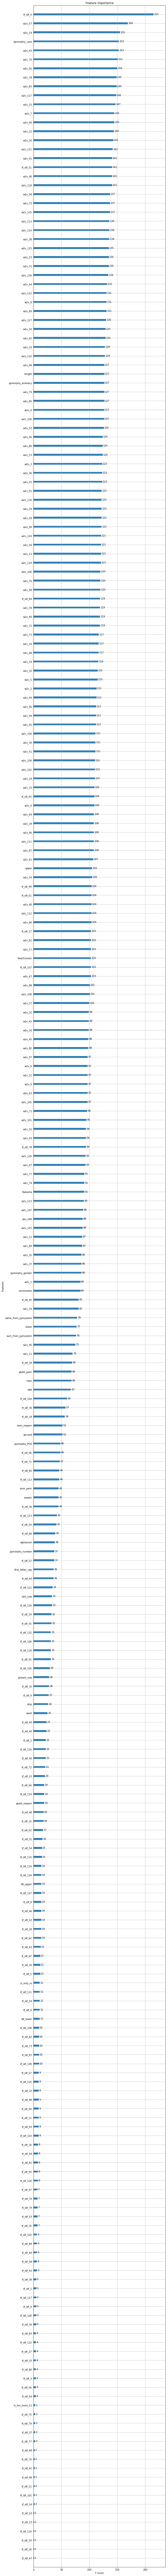

In [102]:
my_plot_importance(model1, (10,200));

In [103]:
x_test = X_pymystem3_test.copy()
d_test = xgb.DMatrix(x_test)
print(X_pymystem3_train.shape, X_pymystem3_test.shape)
sub['Prediction'] = model1.predict(d_test)
sub.head(10)

(101408, 291) (188920, 291)


,Id,Prediction
0,0,0.711431
1,1,0.271203
2,2,0.255145
3,3,0.123873
4,4,0.146918
5,5,0.846458
6,6,0.711785
7,7,0.933987
8,8,0.933987
9,9,0.931613


In [104]:
sub.to_csv('submission_xgb_pymystem3_final_2.csv', columns=['Id', 'Prediction'], index=False)